# 9. 고급 컴퓨터 비전

**감사말**: 프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 9장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.13 이상의 버전에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

**구글 코랩 설정**

'런타임 -> 런타임 유형 변경' 메뉴에서 GPU를 지정한다.
TensorFlow 버전을 확인하려면 아래 명령문을 실행한다.

In [1]:
import tensorflow as tf
tf.__version__

'2.13.1'

TensorFlow가 GPU를 사용하는지 여부를 확인하려면 아래 명령문을 실행한다.
아래와 같은 결과가 나오면 GPU가 제대로 지원됨을 의미한다.

```
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
```

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**참고**

아래 코드에 대한 자세한 설명은
[고급 컴퓨터 비전](https://codingalzi.github.io/dlp2/computer_vision_advanced.html)을 참고한다.

## 9.1 컴퓨터 비전 주요 과제

## 9.2 이미지 분할

**Oxford-IIIT 애완동물 데이터셋 다운로드**

`wget`을 이용하여 사진과 레이블(annotation) 데이터셋을 다운로드한 후에
압축을 푼다.
그러면 images와 annotations 디렉토리가 생성된다.

```
annotations/
...trimaps/             # 트라이맵 분할 마스크(png 파일)
...xmls/
...README/
...list.txt/
...test.txt/
...trainval.txt/
images/                 # 훈련 이미지 데이터셋(jpg 파일)
```

In [5]:
import platform

if platform.system() == 'Linux':
    !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
    !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
    !tar -xf images.tar.gz
    !tar -xf annotations.tar.gz
else:
    import wget, tarfile
    wget.download('http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz')
    wget.download('http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz')

    for aTarfile in ['images.tar.gz', 'annotations.tar.gz']:
        with tarfile.open(aTarfile) as file:
            file.extractall('./')

--2023-11-19 22:38:31--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-11-19 22:38:33--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-11-19 22:38:35--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

**전처리: 데이터 변환**

아래 코드는 입력 데이터로 사용될 이미지와
레이블을 넘파이 어레이로 변환하기 위해 파일들의 경로를 지정한다. 

In [3]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

- `input_img_paths`: 알파벳 순서대로 정렬된 사진 파일의 경로로 구성된 리스트

In [4]:
input_img_paths[:5]

['images/Abyssinian_1.jpg',
 'images/Abyssinian_10.jpg',
 'images/Abyssinian_100.jpg',
 'images/Abyssinian_101.jpg',
 'images/Abyssinian_102.jpg']

- `target_paths`: 알파벳 순서대로 정렬된 타깃 파일의 경로로 구성된 리스트

In [5]:
target_paths[:5]

['annotations/trimaps/Abyssinian_1.png',
 'annotations/trimaps/Abyssinian_10.png',
 'annotations/trimaps/Abyssinian_100.png',
 'annotations/trimaps/Abyssinian_101.png',
 'annotations/trimaps/Abyssinian_102.png']

9번 인덱스 이미지를 확인해보자. 

- `load_img()` 함수: 이미지 파일 불러오기
- `img_to_array()` 함수: 이미지 파일을 어레이로 변환하기

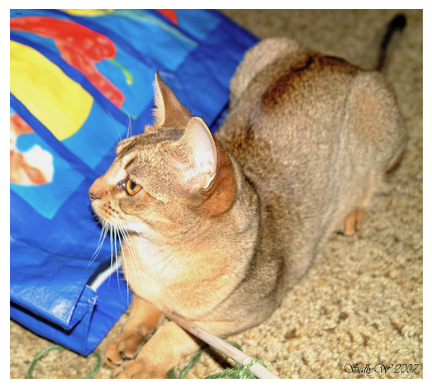

In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

9번 인덱스 이미지에 대한 트라이맵 분할 마스크를 3차원 어레이로 불러오면 다음과 같다.

In [7]:
img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))

이미지의 모양은 다음과 같다.

In [8]:
img.shape

(448, 500, 1)

트라이맵 이미지에 사용된 값을 확인하면 1, 2, 3으로
채워진 것을 확인할 수 있다.

In [9]:
import numpy as np

np.unique(img)

array([1., 2., 3.], dtype=float32)

9번 인덱스 이미지의 트라이맵 분할 마스크를 사진으로 확인하면 다음과 같다.
`display_target()` 함수는 1, 2, 3으로만 구성된 이미지를 흑백사진으로
적합한 값으로 변환한다.

- 1 => 0
- 2 => 127
- 3 => 254

여기서는 트라이맵 분할 마스크를 시각화하기 위해 사용할 뿐이며
모델 훈련에는 활용하지 않는다.

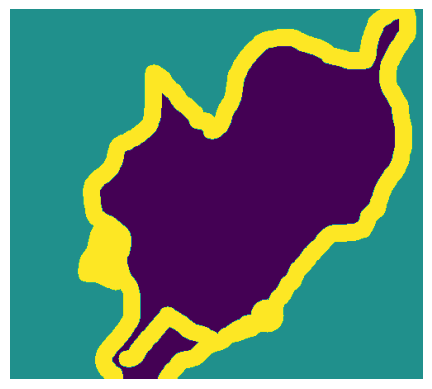

In [10]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

아래 코드의 두 함수는 이미지 파일과 레이블 파일 각각을
지정된 크기의 3차원 어레이로 변환시킨다.
단, 훈련을 위해 이름순으로 정렬된 입력 사진과 타깃을 무작위로 섞는다.
여기서는 코드를 새로 실행해도 동일한 결과를 얻을 수 있도록 시드(seed)를 이용하여 무작위로 섞는다.

또한 이미지 크기를 `(200, 200)`으로 통일시키며, 라벨을 편의성을 위해 1, 2, 3에서 0, 1, 2로 변경한다.

In [11]:
import numpy as np
import random

# 이미지 어레이 크기 지정
img_size = (200, 200)

# 데이터셋 크기
num_imgs = len(input_img_paths)    # 7390

# 무작위 섞기. 동일한 시드 사용.
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

# 훈련 이미지 변환 함수
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

# 레이블 변환 함수
def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1   # 0, 1, 2로 구성
    return img

데이터셋이 매우 작기에 모든 이미지와 레이블을 변환하여 하나의 4차원 어레이로 구현된
이미지 데이터셋과 타깃셋을 생성할 수 있다.

- 이미지 데이터셋 어레이 모양: `(7390, 200, 200, 3)`
- 타깃셋 어레이 모양: `(7390, 200, 200, 1)`

In [12]:
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

In [13]:
input_imgs.shape

(7390, 200, 200, 3)

In [14]:
targets.shape

(7390, 200, 200, 1)

**훈련셋과 검증셋 지정**

1,000개의 검증셋과 나머지로 구성된 훈련셋으로 분리한다. 

In [15]:
num_val_samples = 1000    # 검증셋 크기

# 훈련셋
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]

# 검증셋
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

**모델 구성과 훈련**

이미지 분할 모델의 구성은 기본적으로 `Conv2D` 층으로 구성된 
**다운샘플링** 모듈(downsampling module)과
`Conv2DTranspose` 층으로 구성된 
**업샘플링** 모듈(upsampling module)로 이루어진다.

이미지 분류의 경우와는 달리 맥스풀링을 사용하는 대신 `Conv2D` 층에서 보폭을 2로 
설정하는 이유는 픽셀에 담긴 값(정보) 뿐만 아니라 각 픽셀의 위치도 중요하기 때문이다.
맥스풀링은 이와는 달리 위치와 독립적인 패턴을 알아내는 것이 중요할 때 사용한다.

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

모델 컴파일과 훈련은 특별한 게 없다.

In [17]:
model.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy")

GPU의 성능에 따라 아래 코드를 실행할 때 
`ResourceExhaustedError: Graph execution error` 가 발생하거나
파이썬 서버가 다운될 수 있다.
이유는 입력 데이터 사진의 용량이 커서 GPU의 메모리가 부족해지는 현상이 발생할 수 있기 때문이다.
그런 경우 배치 크기를 16 정도로 줄여야 한다.

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
#                     batch_size=64,
                    batch_size=16,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
400/400 [==============================] - ETA: 0s - loss: 0.8822INFO:tensorflow:Assets written to: oxford_segmentation/assets


INFO:tensorflow:Assets written to: oxford_segmentation/assets


400/400 [==============================] - 42s 79ms/step - loss: 0.8822 - val_loss: 0.7989
Epoch 2/50
399/400 [============================>.] - ETA: 0s - loss: 0.7853INFO:tensorflow:Assets written to: oxford_segmentation/assets


INFO:tensorflow:Assets written to: oxford_segmentation/assets


400/400 [==============================] - 29s 72ms/step - loss: 0.7850 - val_loss: 0.7380
Epoch 3/50
400/400 [==============================] - 28s 70ms/step - loss: 0.7168 - val_loss: 0.8231
Epoch 4/50
399/400 [============================>.] - ETA: 0s - loss: 0.6518INFO:tensorflow:Assets written to: oxford_segmentation/assets


INFO:tensorflow:Assets written to: oxford_segmentation/assets


400/400 [==============================] - 29s 72ms/step - loss: 0.6518 - val_loss: 0.6228
Epoch 5/50
399/400 [============================>.] - ETA: 0s - loss: 0.5925INFO:tensorflow:Assets written to: oxford_segmentation/assets


INFO:tensorflow:Assets written to: oxford_segmentation/assets


400/400 [==============================] - 29s 72ms/step - loss: 0.5924 - val_loss: 0.5352
Epoch 6/50
400/400 [==============================] - 28s 69ms/step - loss: 0.5468 - val_loss: 0.5453
Epoch 7/50
399/400 [============================>.] - ETA: 0s - loss: 0.5138INFO:tensorflow:Assets written to: oxford_segmentation/assets


INFO:tensorflow:Assets written to: oxford_segmentation/assets


400/400 [==============================] - 29s 72ms/step - loss: 0.5137 - val_loss: 0.4838
Epoch 8/50
400/400 [==============================] - 28s 69ms/step - loss: 0.4815 - val_loss: 0.5118
Epoch 9/50
400/400 [==============================] - 28s 70ms/step - loss: 0.4568 - val_loss: 0.7338
Epoch 10/50
399/400 [============================>.] - ETA: 0s - loss: 0.4336INFO:tensorflow:Assets written to: oxford_segmentation/assets


INFO:tensorflow:Assets written to: oxford_segmentation/assets


400/400 [==============================] - 29s 72ms/step - loss: 0.4335 - val_loss: 0.4385
Epoch 11/50
400/400 [==============================] - 29s 72ms/step - loss: 0.4185 - val_loss: 0.7236
Epoch 12/50
399/400 [============================>.] - ETA: 0s - loss: 0.3994INFO:tensorflow:Assets written to: oxford_segmentation/assets


INFO:tensorflow:Assets written to: oxford_segmentation/assets


400/400 [==============================] - 29s 73ms/step - loss: 0.3993 - val_loss: 0.3896
Epoch 13/50
400/400 [==============================] - 29s 74ms/step - loss: 0.3855 - val_loss: 0.4353
Epoch 14/50
400/400 [==============================] - 28s 69ms/step - loss: 0.3745 - val_loss: 0.3902
Epoch 15/50
400/400 [==============================] - 28s 69ms/step - loss: 0.3579 - val_loss: 0.3903
Epoch 16/50
400/400 [==============================] - 28s 70ms/step - loss: 0.3468 - val_loss: 0.3952
Epoch 17/50
400/400 [==============================] - 28s 69ms/step - loss: 0.3308 - val_loss: 0.3924
Epoch 18/50
399/400 [============================>.] - ETA: 0s - loss: 0.3187INFO:tensorflow:Assets written to: oxford_segmentation/assets


INFO:tensorflow:Assets written to: oxford_segmentation/assets


400/400 [==============================] - 29s 72ms/step - loss: 0.3187 - val_loss: 0.3658
Epoch 19/50
400/400 [==============================] - 28s 69ms/step - loss: 0.3086 - val_loss: 0.5312
Epoch 20/50
399/400 [============================>.] - ETA: 0s - loss: 0.2959INFO:tensorflow:Assets written to: oxford_segmentation/assets


INFO:tensorflow:Assets written to: oxford_segmentation/assets


400/400 [==============================] - 29s 72ms/step - loss: 0.2959 - val_loss: 0.3526
Epoch 21/50
400/400 [==============================] - 28s 69ms/step - loss: 0.2840 - val_loss: 0.3680
Epoch 22/50
400/400 [==============================] - 28s 70ms/step - loss: 0.2705 - val_loss: 0.3682
Epoch 23/50
400/400 [==============================] - 28s 69ms/step - loss: 0.2596 - val_loss: 0.4097
Epoch 24/50
400/400 [==============================] - 28s 70ms/step - loss: 0.2459 - val_loss: 0.3769
Epoch 25/50
400/400 [==============================] - 28s 69ms/step - loss: 0.2387 - val_loss: 0.3946
Epoch 26/50
400/400 [==============================] - 31s 78ms/step - loss: 0.2231 - val_loss: 0.3983
Epoch 27/50
400/400 [==============================] - 39s 97ms/step - loss: 0.2131 - val_loss: 0.4117
Epoch 28/50
400/400 [==============================] - 29s 73ms/step - loss: 0.2001 - val_loss: 0.4470
Epoch 29/50
400/400 [==============================] - 27s 69ms/step - loss: 0.1919 -

훈련 결과를 그래프로 시각화해서 보면
과대적합이 20 에퍼크 정도 지나면서 발생함을 확인할 수 있다. 

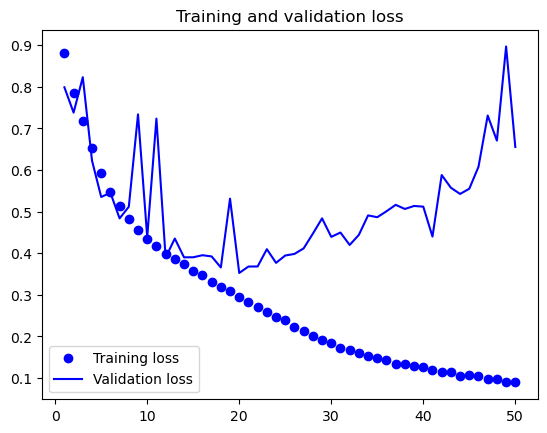

In [19]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

훈련중 저장된 최고 성능의 모델을 불러와서 이미지 분할을
어떻게 진행했는지 하나의 이미지에 대해 테스트해보면
원본 이미지에 포함된 다른 사물이나 배경 때문에 약간의 잡음이 있지만
대략적으로 이미지 분할을 잘 적용함을 알 수 있다.

- `array_to_img()` 함수: 넘파이 어레이를 이미지 파일로 변환

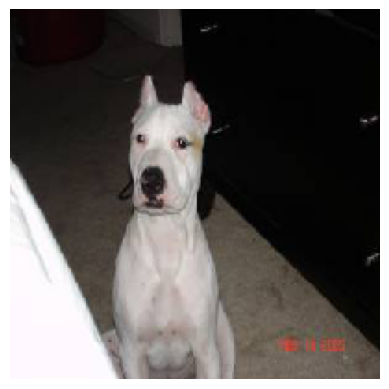

In [21]:
from tensorflow.keras.utils import array_to_img

# 최적의 모델 불러오기
model = keras.models.load_model("oxford_segmentation")

# 검증셋의 4번 인덱스 이미지 확인
i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

테스트 이미지에 대한 이미지 트라이맵 분할 마스크를 
이미지로 재현하면 다음과 같다.

1/1 [==============================] - 0s 493ms/step


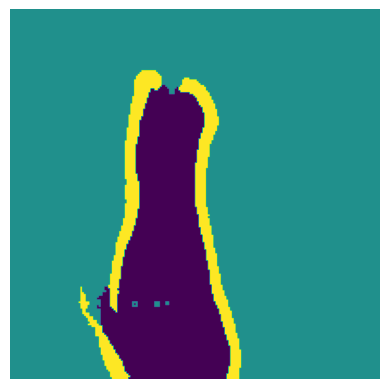

In [22]:
# 테스트 이미지의 트라이맵 분할 마스크 생성
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

## 9.3 CNN 아키텍처 주요 구성요소

### 9.3.1 모듈, 계층, 재활용

### 9.3.2 잔차 연결

**예제**

아래 코드는 잔차 연결을 사용하는 활용법을 보여준다.
맥스풀링과 필터 수에 따른 구분을 사용함에 주의하라.

In [ ]:
# 입력층
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

# 은닉층
def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:                          # 맥스풀링 사용하는 경우
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:  # 필터 수가 변하는 경우
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x) # 채널 별로 하나의 값(채널 평균값) 선택

# 출력층
outputs = layers.Dense(1, activation="sigmoid")(x)

# 모델 설정
model = keras.Model(inputs=inputs, outputs=outputs)

모델 구성 요약은 다음과 같다.

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 32, 32, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   896         rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 32)   9248        conv2d_6[0][0]                   
______________________________________________________________________________________________

### 9.3.3 배치 정규화

### 9.3.4 채널 분리 합성곱

**예제**: Xception 모델

케라스에서 지원하는 Xception 모델의 구성은 2017년 모델과 조금 다르지만
기본적으로 `SeparableConv2D`와 `BatchNormalizaiton` 층을 효율적으로 활용한
모듈을 잔차 연결과 함께 사용하여 깊게 쌓은 모델이다.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.applications.xception.Xception(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

In [ ]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### 9.3.5 미니 Xception 모델

**이미지 다운로드 및 데이터 적재** 

사용하는 데이터셋은 [8장](https://codingalzi.github.io/dlp/notebooks/dlp08_intro_to_dl_for_computer_vision.html)에서 
사용한 캐글(kaggle)의 강아지-고양이 데이터셋이며,
이미지 다운로드와 훈련셋 등의 적재는 8장에서 사용한 방식과 동일하다.

- 캐글 인증서 업로드: 구글 코랩 사용하는 경우

In [ ]:
# 구글 코랩: 캐글 인증서 업로드
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.upload()

print('이어지는 코드는 kaggle.json 파일이 현재 디렉토리에 있다고 가정함.')

이어지는 코드는 kaggle.json 파일이 현재 디렉토리에 있다고 가정함.
아니면 직접 지정된 폴더에 kaggle.json 파일을 저장해야 함.


- 캐글 인증서 저장: kaggle.json 파일이 현재 작업 디렉토리에 있다고 가정함.

In [ ]:
import os, shutil, pathlib

# kaggle 인증서 현재 저장 위치
where_kaggle_json = pathlib.Path("kaggle.json")

# kaggle 인증서를 사용자 홈디렉토리의 ".kaggle/" 디렉토리로 옮기기
if where_kaggle_json.is_file():
    # 홈디렉토리 경로 지정
    homeDir = pathlib.Path.home()
    kaggleDir = homeDir / ".kaggle"
    kaggleJsonFile = kaggleDir / "kaggle.json"

    # ".kaggle" 디렉토리 존재 여부 확인. 없으면 생성.
    if not kaggleDir.is_dir():
        os.makedirs(kaggleDir)

    # "kaggle.json" 파일 존재 여부 확인. 없으면 복사.
    if not kaggleJsonFile.is_file():
        shutil.copyfile(src=where_kaggle_json, 
                        dst=kaggleJsonFile)
        os.chmod(kaggleJsonFile, 0o600)
else:
    print("kaggle.json 파일을 지정된 사용자 홈폴더의 '.kaggle' 폴더에 저장하세요!")

- 강아지-고양이 이미지셋 다운로드 및 압축 해제

In [ ]:
try: 
    !kaggle competitions download -c dogs-vs-cats
except: 
    !pip install kaggle
    !kaggle competitions download -c dogs-vs-cats


  0%|          | 0.00/812M [00:00<?, ?B/s]
  0%|          | 1.00M/812M [00:00<06:50, 2.07MB/s]
  0%|          | 2.00M/812M [00:00<04:24, 3.21MB/s]
  0%|          | 3.00M/812M [00:00<03:00, 4.70MB/s]
  1%|          | 5.00M/812M [00:00<01:56, 7.25MB/s]
  1%|          | 6.00M/812M [00:01<01:49, 7.72MB/s]
  1%|          | 8.00M/812M [00:01<01:23, 10.1MB/s]
  1%|1         | 10.0M/812M [00:01<01:09, 12.0MB/s]
  1%|1         | 12.0M/812M [00:01<01:03, 13.2MB/s]
  2%|1         | 14.0M/812M [00:01<00:59, 14.0MB/s]
  2%|1         | 16.0M/812M [00:01<00:56, 14.7MB/s]
  2%|2         | 18.0M/812M [00:01<00:55, 15.0MB/s]
  2%|2         | 20.0M/812M [00:02<00:55, 15.0MB/s]
  3%|2         | 22.0M/812M [00:02<00:54, 15.2MB/s]
  3%|2         | 24.0M/812M [00:02<00:53, 15.4MB/s]
  3%|3         | 26.0M/812M [00:02<00:55, 14.9MB/s]
  3%|3         | 28.0M/812M [00:02<00:58, 14.0MB/s]
  4%|3         | 30.0M/812M [00:03<01:54, 7.17MB/s]
  4%|3         | 32.0M/812M [00:03<01:42, 8.00MB/s]
  4%|4         | 34.

 60%|#####9    | 486M/812M [00:39<00:14, 24.0MB/s]
 60%|######    | 490M/812M [00:39<00:12, 27.5MB/s]
 61%|######    | 494M/812M [00:39<00:11, 29.6MB/s]
 61%|######1   | 498M/812M [00:39<00:12, 27.1MB/s]
 62%|######1   | 502M/812M [00:39<00:10, 30.3MB/s]
 62%|######2   | 506M/812M [00:39<00:10, 31.9MB/s]
 63%|######2   | 510M/812M [00:39<00:09, 34.3MB/s]
 63%|######3   | 514M/812M [00:40<00:18, 17.1MB/s]
 64%|######3   | 517M/812M [00:40<00:18, 16.7MB/s]
 64%|######4   | 520M/812M [00:40<00:17, 17.2MB/s]
 64%|######4   | 523M/812M [00:40<00:15, 19.6MB/s]
 65%|######4   | 527M/812M [00:41<00:12, 23.2MB/s]
 65%|######5   | 531M/812M [00:41<00:11, 26.2MB/s]
 66%|######5   | 535M/812M [00:41<00:09, 29.8MB/s]
 66%|######6   | 539M/812M [00:41<00:13, 22.0MB/s]
 67%|######6   | 543M/812M [00:41<00:10, 25.7MB/s]
 67%|######7   | 547M/812M [00:42<00:14, 18.6MB/s]
 68%|######7   | 551M/812M [00:42<00:12, 22.4MB/s]
 68%|######8   | 554M/812M [00:42<00:18, 14.9MB/s]
 69%|######8   | 558M/812M [00:

In [ ]:
import zipfile

try:
    with zipfile.ZipFile('train.zip', 'r') as zip_ref:
        zip_ref.extractall('./')
except:
    with zipfile.ZipFile('dogs-vs-cats.zip', 'r') as zip_ref:
        zip_ref.extractall('./')
    with zipfile.ZipFile('train.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

- 강아지-고양이 데이터셋 분류 저장 및 적재

In [ ]:
# 이미지셋 분류 저장 경로 지정
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

# 이미지셋 분류 저장
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

# 데이터셋 적재
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**모델 구현**

- 데이터 증식 층

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

- 미니 Xception 모델 구성

In [ ]:
# 입력층
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)

# 하나의 Conv2D 은닉층
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

# SeparableConv2D, BatchNormalization, MaxPooling2D 층으로 구성된 모듈 쌓기
# 잔차 연결 활용
for size in [32, 64, 128, 256, 512]:   # 필터 수
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # 잔차 연결
    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

# 마지막 은닉층은 GlobalAveragePooling2D과 Dropout
x = layers.GlobalAveragePooling2D()(x)    # flatten 역할 수행(채널 별 평균값으로 구성)
x = layers.Dropout(0.5)(x)

# 출력층
outputs = layers.Dense(1, activation="sigmoid")(x)

# 모델 지정
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 176, 176, 32) 2400        rescaling_1[0][0]                
____________________________________________________________________________________________

- 모델 훈련

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="mini_xception",
        save_best_only=True,
        monitor="val_loss")
    ]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 32s 310ms/step - loss: 0.7129 - accuracy: 0.5650 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/100


C:\Users\gslee\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


63/63 [==============================] - 19s 297ms/step - loss: 0.6554 - accuracy: 0.6060 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 19s 304ms/step - loss: 0.6460 - accuracy: 0.6355 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 19s 304ms/step - loss: 0.6223 - accuracy: 0.6575 - val_loss: 0.7169 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 19s 307ms/step - loss: 0.6103 - accuracy: 0.6760 - val_loss: 0.7466 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 19s 300ms/step - loss: 0.5881 - accuracy: 0.6965 - val_loss: 0.7633 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 19s 299ms/step - loss: 0.5711 - accuracy: 0.7045 - val_loss: 0.8972 - val_accuracy: 0.5000
Epoch 8/100
63/63 [==============================] - 19s 299ms/step - loss: 0.5621 - accuracy: 0.7125 - val_loss: 0.7046 - val_accuracy: 0.5520
Epoc

과대적합은 50번 정도의 에포크 실행 후에 발생한다.

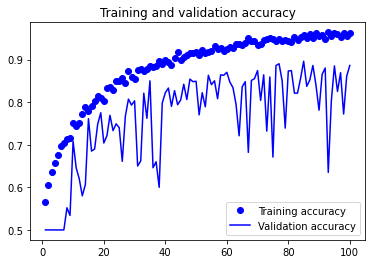

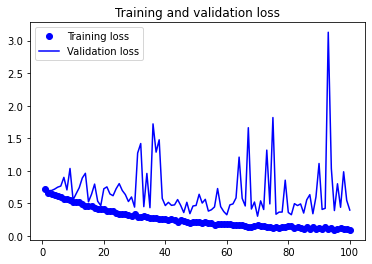

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# 정확도 그래프
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

# 손실 그래프
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

* 훈련 성능 평가

직접 구현한 모델이지만 테스트셋에 대한 정확도가 90% 정도 나온다. 
8장에서 직접 구현해서 훈련시켰을 때의 성능인 83% 정도보다 훨씬 높게 나온다.

In [ ]:
test_model = keras.models.load_model("mini_xception")

test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 19ms/step - loss: 0.3141 - accuracy: 0.8785
Test accuracy: 0.878


**성능 높이기**

보다 성능을 높이려면 하이퍼파라미터 미세조정 및 앙상블 학습을 활용해야 한다(13장 참조).

- 하이퍼파라미터 미세조정: [케라스튜너(KerasTuner)](https://www.tensorflow.org/tutorials/keras/keras_tuner) 활용
- 앙상블 학습: [그레이디언트 부스팅(gradient boosting)](https://codingalzi.github.io/handson-ml2/notebooks/handson-ml2-07.html) 활용